# First Time Setups

Install Stockfish

In [ ]:
!   wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
    unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt

--2023-05-11 00:55:42--  https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.159.9, 104.25.158.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.159.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28531469 (27M) [application/zip]
Saving to: ‘stockfish_14_linux_x64_popcnt.zip.2’

stockfish_14_linux_ 100%[===================>]  27.21M  7.95MB/s    in 4.3s    

2023-05-11 00:55:47 (6.29 MB/s) - ‘stockfish_14_linux_x64_popcnt.zip.2’ saved [28531469/28531469]

Archive:  stockfish_14_linux_x64_popcnt.zip
replace stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Import required libraries

In [ ]:
!pip install chess
!pip install python-lichess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Functionality

In [ ]:
import chess, chess.engine
import os
import random
import numpy

Define a function to create a reachable random board

In [ ]:
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)
  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break
  return board

Define a function to get the Stockfish rating of a board

In [ ]:
sf = chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")
def stockfish(board,depth=10):
  result = sf.analyse(board, chess.engine.Limit(depth=depth))
  output = result['score'].white().score()
  if output is None: return 0
  return output

Test out the random_board and stockfish functions

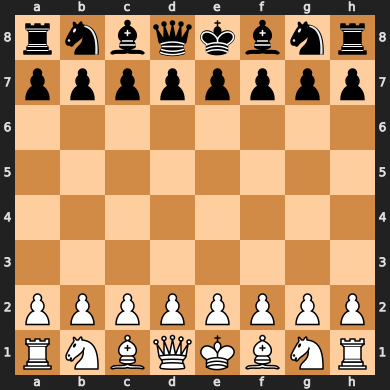

In [ ]:
board = random_board()
board

In [ ]:
print(stockfish(board))

32


Define functions to convert random_boards to data that Tensorflow can process  
This creates a (14,8,8) numpy array that stores where the pieces are located and which ones are under attack, using only 1's and 0's

In [ ]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

Test on the board generated

In [ ]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

# Create Data

In [ ]:
import numpy as np

Delete the datafile if it exists, just in case

In [ ]:
if os.path.exists("100.npz"):
  os.remove("100.npz")
  print("Deleted old dataset")
else:
  print("Dataset not in path")

Dataset not in path


Create a bunch of numpy arrays and store them in the dataset file

In [ ]:
num_samples = 100
boards = [random_board() for i in range(num_samples)]
b = np.array([split_dims(board) for board in boards])
v = np.array([stockfish(board) for board in boards])

v

array([  800,  -784,  -838,   -99,  -215,  -225, -1261,  -281, -2946,
         787, -1069, -2123,    97, -1728,     0,  8497,    54,  1062,
        1838,  -769, -1492, -2690,  -565,   623,  1669,  -116,  -161,
       -1378,  1713,  1269,  -169,    39,  1096,   712,  -415,  -511,
        -276,  1012, -5717,  -647, -1284,  -640,   860,     0, -2369,
        -755,  1081, -2238, -1756, -1462,    69,     0,  1126,  -118,
        -976,     0,  3046,   -31,  1175,   760,   707,  -232,  -842,
       -1301,     0,   604,  1307,   845,  -953,   508,   -63,   872,
        1607,   961,  -593,    54,  1230,  1069,   907,  -337,  7313,
         730,   307,  -510,  1853, -1454, -1015,  -761,  -119,   656,
         723,  -384,   784,  1315,  -549,    75, -8174,  -357,  -905,
       -1484,   536, -2646,  2038,   368,   446,  1484,  1484,   356,
           0,   -13,   900,  -144,    65,     0,  1333,  -678,   829,
        1192,     0, -1738,  2869,  -341,  1037,   129,  -327, -1530,
        -992,   103,

In [ ]:
numpy.savez("100", b=b, v=v)

# TensorFlow Model

Import Tensorflow libraries

In [ ]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

Build the model, stack layers

In [ ]:
def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Build the model, stack layers

In [ ]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Create the model

In [ ]:
model = build_model(32, 4)

# Train Model

Load `dataset.npz`, where the numpy arrays where stored.  
Should output the sizes of the arrays, and the first numbers should match.

In [ ]:
import tensorflow.keras.callbacks as callbacks


def get_dataset():
	container = numpy.load('100.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1000, 14, 8, 8)
(1000,)


Fit the data into the model, and save the model into a file so that it can be loaded.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
checkpoint_filepath = '/tmp/checkpoint/'
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])

model.save('100')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 8, 32)         2336      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten_1 (Flatten)         (None, 3584)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2294

1/1 [==============================] - 4s 4s/step - loss: 0.0078 - val_loss: 0.0098 - lr: 5.0000e-04
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 2s 2s/step - loss: 0.0076 - val_loss: 0.0089 - lr: 5.0000e-04
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 3s 3s/step - loss: 0.0075 - val_loss: 0.0088 - lr: 5.0000e-04
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0073 - val_loss: 0.0090 - lr: 5.0000e-04
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0070 - val_loss: 0.0092 - lr: 5.0000e-04
Epoch 6/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069

1/1 [==============================] - 4s 4s/step - loss: 0.0069 - val_loss: 0.0087 - lr: 5.0000e-04
Epoch 7/1000
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 4s 4s/step - loss: 0.0066 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 8/1000
1/1 [==============================] - ETA: 0s - loss: 0.0064

1/1 [==============================] - 3s 3s/step - loss: 0.0064 - val_loss: 0.0079 - lr: 5.0000e-04
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0062 - val_loss: 0.0081 - lr: 5.0000e-04
Epoch 10/1000
1/1 [==============================] - ETA: 0s - loss: 0.0059

1/1 [==============================] - 2s 2s/step - loss: 0.0059 - val_loss: 0.0079 - lr: 5.0000e-04
Epoch 11/1000
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0075 - lr: 5.0000e-04
Epoch 12/1000
1/1 [==============================] - 1s 777ms/step - loss: 0.0057 - val_loss: 0.0077 - lr: 5.0000e-04
Epoch 13/1000
1/1 [==============================] - 1s 799ms/step - loss: 0.0054 - val_loss: 0.0076 - lr: 5.0000e-04
Epoch 14/1000
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 2s 2s/step - loss: 0.0053 - val_loss: 0.0073 - lr: 5.0000e-04
Epoch 15/1000
1/1 [==============================] - 1s 798ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 5.0000e-04
Epoch 16/1000
1/1 [==============================] - 1s 792ms/step - loss: 0.0050 - val_loss: 0.0074 - lr: 5.0000e-04
Epoch 17/1000
1/1 [==============================] - ETA: 0s - loss: 0.0048

1/1 [==============================] - 3s 3s/step - loss: 0.0048 - val_loss: 0.0072 - lr: 5.0000e-04
Epoch 18/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0048 - val_loss: 0.0074 - lr: 5.0000e-04
Epoch 19/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0045 - val_loss: 0.0075 - lr: 5.0000e-04
Epoch 20/1000
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 2s 2s/step - loss: 0.0044 - val_loss: 0.0071 - lr: 5.0000e-04
Epoch 21/1000
1/1 [==============================] - 1s 792ms/step - loss: 0.0044 - val_loss: 0.0072 - lr: 5.0000e-04
Epoch 22/1000
1/1 [==============================] - 1s 774ms/step - loss: 0.0042 - val_loss: 0.0075 - lr: 5.0000e-04
Epoch 23/1000
1/1 [==============================] - 1s 804ms/step - loss: 0.0042 - val_loss: 0.0071 - lr: 5.0000e-04
Epoch 24/1000
1/1 [==============================] - 1s 798ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 5.0000e-04
Epoch 25/1000
1/1 [==============================] - 1s 771ms/step - loss: 0.0038 - val_loss: 0.0076 - lr: 5.0000e-04
Epoch 26/1000
1/1 [==============================] - 1s 808ms/step - loss: 0.0038 - val_loss: 0.0072 - lr: 5.0000e-04
Epoch 27/1000
1/1 [==============================] - 1s 788ms/step - loss: 0.0038 - val_loss: 0.0075 - lr: 5.0000e-04
Epoch 28/1000
1/1 [==============================] - 1s 783ms/step - loss

# Stockfish vs Model position rating

Generate a random board, and have both the model and stockfish rate it

In [ ]:
board = random_board()

from tensorflow.keras import models
model = models.load_model('1000')

def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]

print(f'\n{board}')
print("Stockfish (not normalized):", stockfish(board))
print("TensorFlow:", minimax_eval(board))


. . . . . . b .
. . . . . . k .
. . . . . N . p
. . . . B . . P
P P . . . . . .
. . r . . . . .
. . . . . . . .
. . . . . . . K
Stockfish (not normalized): 890
TensorFlow: tf.Tensor(0.51143026, shape=(), dtype=float32)


# Gametree Implementation

Import model from file!

In [ ]:
from tensorflow.keras import models
model = models.load_model('1000')

Minimax, with alpha beta pruning.

In [ ]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

Test the AI vs installed Stockfish engine, automatically moving pieces.

In [ ]:
# Testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output
with chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt") as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('gg')
            break
        move = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('gg')
            break


r n b . k . . r
p . . p . p p p
. . p . p . . .
. . b . P . . .
. . . . . . . .
. . . . . q . .
. . P P . P . P
. . . . . K . .

r n b . k . . r
p . . p . p p p
. . p . p . . .
. . b . P . . .
. . . . . . . .
. . . . . . . .
. . P P . q . P
. . . . . K . .
gg


Display Stockfish annihilating the AI, because it is a pale imitation of the original

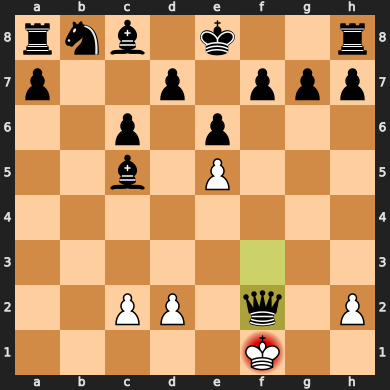

In [ ]:
board

In [ ]:
# Move by move testing code AI(white) vs user(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt") as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('gg')
            break
        input_var = input()
        move = chess.Move.from_uci(input_var)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('gg')
            break

g1f3

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R


KeyboardInterrupt: ignored